In [174]:
# Bringing in relevant libraries 
import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm, chi2_contingency, chi2 
import matplotlib.pyplot as plt


In [175]:
# importing conversion summary data
df = pd.read_csv('conversion_tracker_v2.csv')

# calculating relevant rates
df['conversion_rate'] = df['Conversions'] / df['Population']
df['ctr']=df['Unique_Clicks']/df['Population']
df['cac']=df['Spend']/df['Conversions']

In [176]:
# conversion summary
df['conversion_rate']=((df.Conversions/df.Population)*100).round(3).astype(str) + '%'
conversion_summary =pd.DataFrame(df[['Variation','Population','Conversions','conversion_rate']])
print(conversion_summary)

  Variation  Population  Conversions conversion_rate
0   Control    20014153        19815          0.099%
1      Test    20214295        23007          0.114%


In [177]:
# checking to see if conversion lifts were stat sign

# changing format to do statistical calculation 
df['Population'] = pd.to_numeric(df['Population'])
df['Conversions'] = pd.to_numeric(df['Conversions'])
df['conversion_rate'] = df['Conversions'] / df['Population']
df['Spend'] = pd.to_numeric(df['Spend'])

# Control and test groups
control_conversion_rate = df.loc[df['Variation'] == 'Control', 'conversion_rate'].values[0]
test_conversion_rate = df.loc[df['Variation'] == 'Test', 'conversion_rate'].values[0]

# standard erro
pooled_std_error = ((control_conversion_rate * (1 - control_conversion_rate) / df.loc[df['Variation'] == 'Control', 'Population'].values[0]) +
                   (test_conversion_rate * (1 - test_conversion_rate) / df.loc[df['Variation'] == 'Test', 'Population'].values[0])) ** 0.5

# z-score
z_score = (test_conversion_rate - control_conversion_rate) / pooled_std_error

# pvalue, using two tailed 
p_value = norm.sf(abs(z_score)) * 2

alpha = 0.05

if p_value < alpha:
    print("Conversion rate is Stat Sig.P-value=" ,p_value)
else:
    print("Conversion rates is not Stat Sig.P-value.P-value=",p_value)

conversion_summary

Conversion rate is Stat Sig.P-value= 4.576212185289589e-47


,Variation,Population,Conversions,conversion_rate
0,Control,20014153,19815,0.099%
1,Test,20214295,23007,0.114%


In [178]:
# cac summary

cac_summary =df[['Variation','Spend','Conversions','cac']]
cac_summary

,Variation,Spend,Conversions,cac
0,Control,1010476,19815,50.995508
1,Test,1020581,23007,44.359586


In [179]:

# adding conversions by customer segment to dataframe
segmentA = ['9906', '10504']
segmentB= ['9909', '12503']

df['segmentA'] = segmentA
df['segmentB'] = segmentB

df['segmentA'] = df['segmentA'].astype('int')
df['segmentB'] = df['segmentB'].astype('int')

# calculating segment mix of conversions

df['segmentA_pct']=(df.segmentA/df.Conversions)*100
df['segmentB_pct']=(df.segmentB/df.Conversions)*100

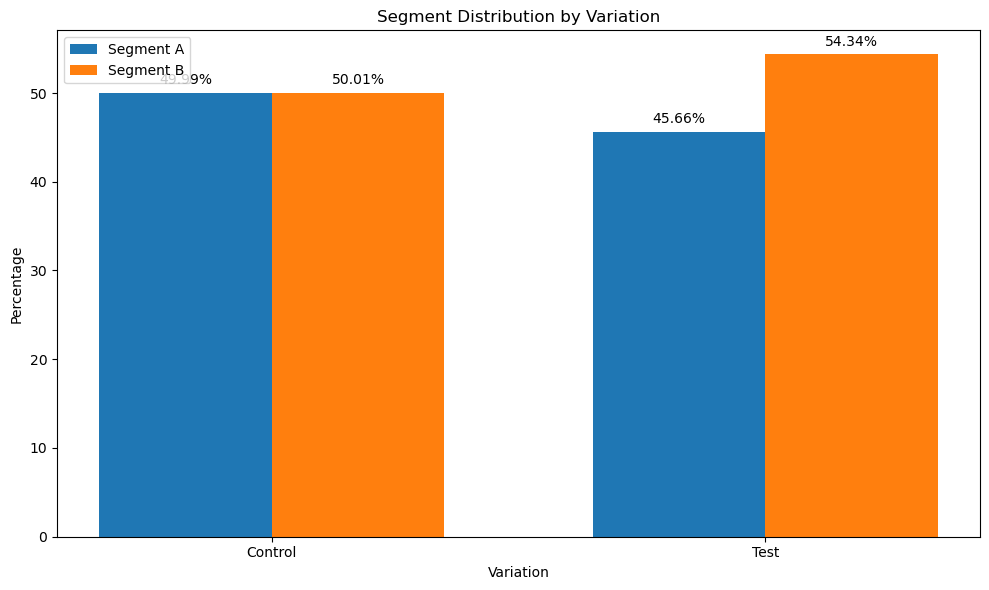

In [180]:
## plotting segment_mix
segment_mix = df[['Variation','segmentA_pct','segmentB_pct']]

plt.figure(figsize=(10, 6))
bar_width = 0.35
bar_positions = range(len(df))

plt.bar(bar_positions, df['segmentA_pct'], width=bar_width, label='Segment A')
plt.bar([pos + bar_width for pos in bar_positions], df['segmentB_pct'], width=bar_width, label='Segment B')

plt.xlabel('Variation')
plt.ylabel('Percentage')
plt.title('Segment Distribution by Variation')
plt.xticks([pos + bar_width / 2 for pos in bar_positions], df['Variation'])
plt.legend()
plt.tight_layout()


for i, row in df.iterrows():
    plt.text(i, row['segmentA_pct'] + 1, f"{row['segmentA_pct']:.2f}%", ha='center')
    plt.text(i + bar_width, row['segmentB_pct'] + 1, f"{row['segmentB_pct']:.2f}%", ha='center')

plt.show()

In [181]:
# importing data for lifetime performance of test groups
df2 = pd.read_csv('lifetimedata.csv')

In [182]:
## adding profit and revenue 
## using the following from case study file
# interchange revenue rate = 1.5% of total purchase amount
# interchange cost = 1.05% of total purchase amount

df2['total_purchase_dollars'] = pd.to_numeric(df2['total_purchase_dollars'])
df2['interchange_revenue']=df2['total_purchase_dollars'].mul(.0150)
df2['interchange_cogs']=df2['total_purchase_dollars'].mul(.0105)
df2['spend_tracker_active_user_count_cost'] = df2['spend_tracker_active_user_count'].mul(5)
## calculating profit
df2['interchange_profit']=df2['interchange_revenue']-df2['interchange_cogs']
df2['profit']= df2['interchange_profit']-df2['spend_tracker_active_user_count_cost']


In [183]:
## calculating LTV of overall where LTV = profit per user/ churn rate

## profit per user calculated in steps below

## total profit
df2['profit_by_test_group'] = df2.groupby("test_group")["profit"].sum()

## user count at start (which will equal our user count in profit per user)
starting_users = df2.loc[df2['months_since_conversion'] == 0]
user_count = starting_users.groupby("test_group")["active_user_count"].sum()

## profit per user
profit_per_user = profit_by_test_group/user_count

## churn rate

## get first and last monght user counts 
first_month = df2.loc[df2['months_since_conversion'] == 0]
last_month = df2.loc[df2['months_since_conversion'] == 18]
first_month_user_count = first_month.groupby("test_group")["active_user_count"].sum()
last_month_user_count = last_month.groupby("test_group")["active_user_count"].sum()

## caclulate churn rate

churn_rate = 1-last_month_user_count/first_month_user_count



## LTV
ltv = profit_per_user/churn_rate




print(ltv,profit_per_user,churn_rate)




test_group
Control    238.305317
Test       236.532613
dtype: float64 test_group
Control    87.300444
Test       80.314373
dtype: float64 test_group
Control    0.366339
Test       0.339549
Name: active_user_count, dtype: float64


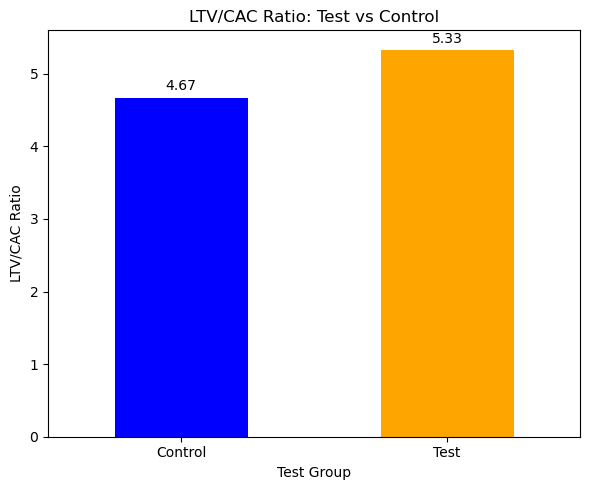

In [125]:
## calculate LTV/CAC ration and plot it

cac_total = df.groupby("Variation")["cac"].sum()
ltv_cac_ratio= ltv/cac_total.round(2)


fig, ax = plt.subplots(figsize=(6, 5))
bars = ltv_cac_ratio.plot(kind='bar', color=['blue', 'orange'], ax=ax)
plt.xlabel('Test Group')
plt.ylabel('LTV/CAC Ratio')
plt.title('LTV/CAC Ratio: Test vs Control')
plt.xticks(rotation=0)

for bar in ax.patches:
    yval = bar.get_height()
    ax.annotate(f'{yval:.2f}',  
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

l

In [184]:
## calculating LTV of  customer segments  where LTV = profit per user by customer segment / churn rate by customer segment

## profit per user calcs below

## total profit
profit_by_test_group_segment = df2.groupby(["test_group","segment"])["profit"].sum()

## user count at start (which will equal our user count in profit per user)
starting_users_segment = df2.loc[df2['months_since_conversion'] == 0]
user_count_segment = starting_users_segment.groupby(["test_group","segment"])["active_user_count"].sum()


## profit per user
profit_per_user_segment = profit_by_test_group_segment/user_count_segment

## churn rate

## get first and last monght user counts 
first_month = df2.loc[df2['months_since_conversion'] == 0]
last_month = df2.loc[df2['months_since_conversion'] == 18]
first_month_user_count_segment = first_month.groupby(["test_group","segment"])["active_user_count"].sum()
last_month_user_count_segment = last_month.groupby(["test_group","segment"])["active_user_count"].sum()

## caclulate churn rate

churn_rate_segment = 1-last_month_user_count_segment/first_month_user_count_segment

## LTV
ltv_segment = profit_per_user_segment/churn_rate_segment

print(ltv_segment,profit_per_user_segment,churn_rate_segment)

test_group  segment  
Control     Segment A    197.427271
            Segment B    283.461988
Test        Segment A    179.509251
            Segment B    289.636941
dtype: float64 test_group  segment  
Control     Segment A    75.933566
            Segment B    98.663881
Test        Segment A    64.376556
            Segment B    93.704025
dtype: float64 test_group  segment  
Control     Segment A    0.384615
            Segment B    0.348067
Test        Segment A    0.358625
            Segment B    0.323522
Name: active_user_count, dtype: float64


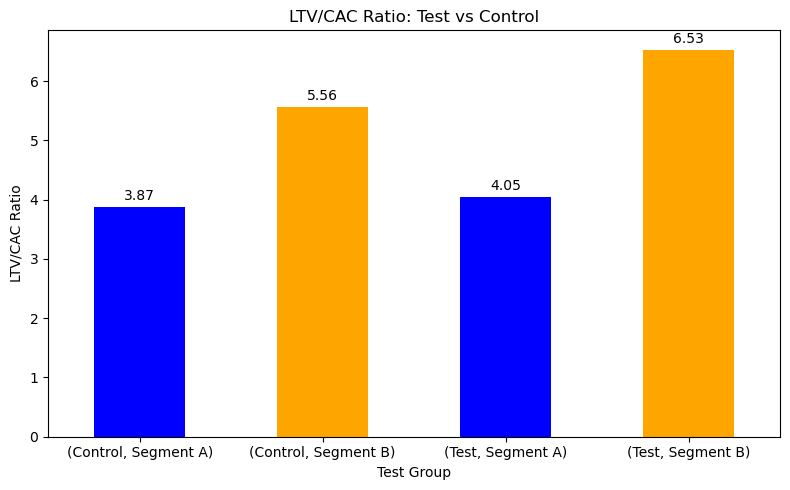

In [151]:

# plotting LTV/CAC ration by segment group

data = {'test_group': ['Control', 'Control', 'Test', 'Test'],
        'segment': ['Segment A', 'Segment B', 'Segment A', 'Segment B'],
        'cac': [50.995508, 50.995508,  44.359586,  44.359586]}
 
cac_segment = pd.DataFrame(data)

cac_segment = cac_segment.groupby(["test_group","segment"])["cac"].max()

ltv_cac_ratio= ltv_segment/cac_segment.round(2)



fig, ax = plt.subplots(figsize=(8, 5))
bars = ltv_cac_ratio.plot(kind='bar', color=['blue', 'orange'], ax=ax)
plt.xlabel('Test Group')
plt.ylabel('LTV/CAC Ratio')
plt.title('LTV/CAC Ratio: Test vs Control')
plt.xticks(rotation=0)


for bar in ax.patches:
    yval = bar.get_height()
    ax.annotate(f'{yval:.2f}',  
                xy=(bar.get_x() + bar.get_width() / 2, yval),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

                         feature_usage
months_since_conversion               
0                             0.210542
1                             0.212278
2                             0.215032
3                             0.214471
4                             0.218216
5                             0.217053
6                             0.222196
7                             0.219344
8                             0.224539
9                             0.225290
10                            0.227723
11                            0.227879
12                            0.227138
13                            0.231622
14                            0.231734
15                            0.233274
16                            0.238117
17                            0.236710
18                            0.239791


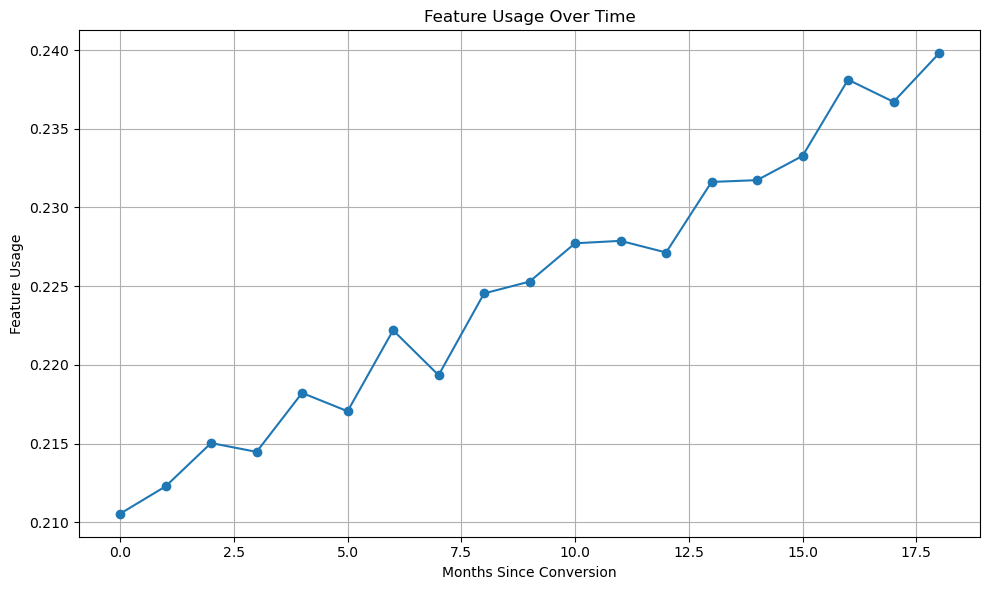

In [185]:
# plotting feature usage over time

df2['feature_usage']=df2['spend_tracker_active_user_count']/df2['active_user_count']

pivot_table_all = df2.pivot_table(index=["months_since_conversion"], values=["feature_usage"])

print(pivot_table_all)

plt.figure(figsize=(10, 6))
plt.plot(pivot_table_all.index, pivot_table_2['feature_usage'], marker='o')

plt.xlabel('Months Since Conversion')
plt.ylabel('Feature Usage')
plt.title('Feature Usage Over Time')
plt.grid(True)
plt.tight_layout()

plt.show()


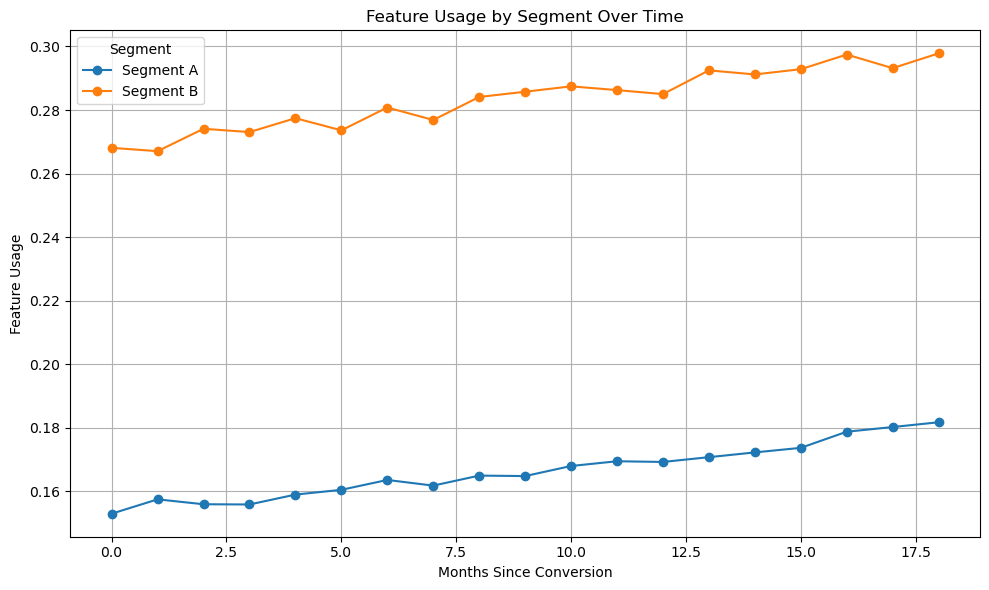

In [186]:
# plotting feature usage by segment over time

pivot_table = df2.pivot_table(index=["months_since_conversion"], columns=["segment"], values=["feature_usage"])

plt.figure(figsize=(10, 6))

for column in pivot_table.columns.levels[1]:
    plt.plot(pivot_table.index, pivot_table[('feature_usage', column)], marker='o', label=column)

plt.xlabel('Months Since Conversion')
plt.ylabel('Feature Usage')
plt.title('Feature Usage by Segment Over Time')
plt.legend(title='Segment')
plt.grid(True)
plt.tight_layout()

plt.show()

In [187]:
# printing profitability summary for customer segments 


data = {
    'profit_per_user': [87.3, 80.3],
    'churn_rate': [0.366, 0.339],
    'ltv': [238.30, 236.5]
}

ltv_summary = pd.DataFrame(data)

ltv_summary = ltv_summary.rename(index={0: 'control', 1: 'test'})

#edit format
ltv_summary['profit_per_user'] = ltv_summary['profit_per_user'].apply(lambda x: f'${x:.2f}')
ltv_summary['ltv'] = ltv_summary['ltv'].apply(lambda x: f'${x:.2f}')
ltv_summary['churn_rate'] = ltv_summary['churn_rate'].apply(lambda x: f'{x:.2%}')

print(ltv_summary)






        profit_per_user churn_rate      ltv
control          $87.30     36.60%  $238.30
test             $80.30     33.90%  $236.50


In [188]:

# printing profitability summary for customer segments 

data_segment = {
    'profit_per_user_segment': [75.93, 98.63,64.37,93.70],
    'churn_rate_segment': [0.384, 0.348,0.358,.323],
    'ltv_segment': [197.42, 283.46,179.59,289.63]
}


ltv_summary_segment = pd.DataFrame(data_segment)

ltv_summary_segment = ltv_summary_segment.rename(index={0: 'control_segment_A', 1: 'control_segment_B',2:'test_segment_A',3:'test_segment_B'})

#edit format

ltv_summary_segment['profit_per_user_segment'] = ltv_summary_segment['profit_per_user_segment'].apply(lambda x: f'${x:.2f}')
ltv_summary_segment['ltv_segment'] = ltv_summary_segment['ltv_segment'].apply(lambda x: f'${x:.2f}')
ltv_summary_segment['churn_rate_segment'] = ltv_summary_segment['churn_rate_segment'].apply(lambda x: f'{x:.2%}')

print(ltv_summary_segment)




                  profit_per_user_segment churn_rate_segment ltv_segment
control_segment_A                  $75.93             38.40%     $197.42
control_segment_B                  $98.63             34.80%     $283.46
test_segment_A                     $64.37             35.80%     $179.59
test_segment_B                     $93.70             32.30%     $289.63


In [199]:
# formatting cac to $

cac_summary =df[['Variation','Spend','Conversions','cac']]

cac_summary = pd.DataFrame(cac_summary)
cac_summary['cac'] = cac_summary['cac'].round(2)

cac_summary['cac'] = '$' + cac_summary['cac'].astype(str)

cac_summary

,Variation,Spend,Conversions,cac
0,Control,1010476,19815,$51.0
1,Test,1020581,23007,$44.36
